# 1: Data Processing

## 1.1 Data Gathering

### Introduction

Public bike rental schemes have been launched in many cities around Europe, including successful networks in Irish towns and cities such as Dublin, Cork, and Galway. These provide local active transport links for commuting and leisure. This project explores the publically available data pertaining to the Dublin bike network, makes comparisons to the London network run by Santander, and makes recommendations on network adjustments that could be made to improve the network.

There are several data sources to pull from and process:

Data pertaining to the Dublin bike scheme - number of hires, availability, locations of stations, etc.
- https://data.gov.ie/dataset/dublinbikes-api - Historical data for Dublin bike hire (CSV format)
- https://developer.jcdecaux.com/#/opendata/vls?page=static&contract=dublin - (JSON format)

Similar data pertaining to the London bike scheme in order provide a point of comparison.
- https://data.london.gov.uk/dataset/number-bicycle-hires - The number of bicycle hires in London (XLS format)
- https://data.london.gov.uk/dataset/cycle-hire-availability - The availability of bike hires in London

Population data for the Dublin area. It is possible that the population in the vicinity of bike stations plays a significant role in their usage/availability, so this is gathered to enable features to be derived relating to this.
- https://ie-cso.maps.arcgis.com/apps/webappviewer/index.html?id=0fe164e96d254776866425e2fd3e73af - 2022 census population data for Dublin (GIS data)
- https://gisco-services.ec.europa.eu/grid/GISCO_grid_metadata.pdf - GIS grid data for Europe (GIS data / parquet)

Weather data for Dublin - it is possible that the weather (temperature/rainfall) has a role in bike usage, so this is gathered in order to explore this link.
- https://www.met.ie/climate/available-data/historical-data - Historical weather data for Dublin (CSV format)

Reddit search data - In order to investigate sentiment towards cycling, bike share schemes, and transport, reddit data was retrieved using their API and saved as json files - https://www.reddit.com/dev/api/

These data sources are publically available with very few restrictions - they generally ask that the sources are given attribution and it is noted if changes are made. 
- Dublinbikes and met eireann data are available under the creative commons license version 4.0 - https://creativecommons.org/licenses/by/4.0/
- The UK open government license requests that a link to the license is included, which han be found here - https://www.nationalarchives.gov.uk/doc/open-government-licence/version/2/
- European population grid data is publically available for non-commercial purposes with attribution - https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/population-distribution-demography
- Reddit has a terms of use for their api, which includes stipulations such as that it must be accessed using Oauth2, and it must not be used for illegal activity - https://www.reddit.com/wiki/api-terms/

---

In order for this notebook to be reproducible, where possible, data downloads have been carried out within the code in folders defined and created here. This avoids any user-error that could arise with manually downloading and managing file structures.

Additionally, pip installations are managed using a requirements.txt file, which allows all installations to be carried out with one line and also allows a record of the dependencies to exist in version control.

In [ ]:
## unquote to install dependencies from file if not already installed
# pip install -r requirements.txt

In [15]:
import os
from pathlib import Path
import json
import yaml
import time
import pyproj
import datetime
import zipfile
import requests
from requests.auth import HTTPBasicAuth
import unittest
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from bs4 import BeautifulSoup
from tqdm import tqdm
from tqdm.contrib import itertools
from itertools import chain
from pprint import pprint


import warnings
warnings.filterwarnings('ignore')

# Flag to control redownloading - avoids unnecessary web traffic
REDOWNLOAD = False

# Flag to control reevaluation for expensie one-off operations (such as processing and combining data files into representations that are subsequently written to disc)
REEVAL = True

data_folder = Path('data/')
dublin_bike_folder = Path('data/dublinbikes')

if not data_folder.exists():
    data_folder.mkdir()
    
if not dublin_bike_folder.exists():
    dublin_bike_folder.mkdir()
    (dublin_bike_folder / 'monthly').mkdir()
    (dublin_bike_folder / 'quarterly').mkdir()

sentiment_folder = Path('data/sentiment')
if not sentiment_folder.exists():
    sentiment_folder.mkdir()
    (sentiment_folder / 'dublin').mkdir()
    (sentiment_folder / 'london').mkdir()
    
weather_folder = Path('data/weather')
if not weather_folder.exists():
    weather_folder.mkdir()

### 1.1.1 Dublin Bikes Data

Firstly, to get dublinbikes historical data, the download links are scraped from the dublinbikes data page data.gov.ie. BeautifulSoup is used for this, which allows us to parse the html response from a get request to the data landing page, and filter down to the 'a' tags which have a dublinbike .csv href. These come in quarterly and monthly cadences, so the list of links can be split based on the url format, and each file can be downloaded using pandas, with the os path basename allowing us to easily parse out the filename from the url.

In [8]:
# dublinbikes csv data
main_page_url = 'https://data.gov.ie/dataset/dublinbikes-api'
main_page_html = requests.get(main_page_url).content

In [17]:
soup = BeautifulSoup(main_page_html)
download_links = [a['href'] for a in soup.find_all('a', href=True) if a['href'].endswith('.csv') and 'dublinbike' in a['href']]
download_links 

['https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/9496fac5-e4d7-4ae9-a49a-217c7c4e83d9/download/dublinbikes_20180701_20181001.csv',
 'https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/67ea095f-67ad-47f5-b8f7-044743043848/download/dublinbikes_20181001_20190101.csv',
 'https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/538165d7-535e-4e1d-909a-1c1bfae901c5/download/dublinbikes_20190101_20190401.csv',
 'https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/76fdda3d-d8be-441b-92dd-0ee36d9c5316/download/dublinbikes_20190401_20190701.csv',
 'https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/305d39ac-b6a0-4216-a535-0ae2ddf59819/download/dublinbikes_20190701_20191001.csv',
 'https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/5d23332e-4f49-4c41-b6a0-bffb77b33d64/download/dublinbikes_20191001_20200101.csv',
 'ht

These files can be quite large, so we set a flag to avoid redownloading them if not needed.

We also use tqdm to display simple progress bars, as the data takes a reasonably long time to download. 

In [27]:
# Warning: this downloads several Gbs of bike data
quarterly_links = [x for x in download_links if 'dublinbikes' in x]
monthly_links = [x for x in download_links if 'dublinbikes' not in x]

if REDOWNLOAD:
    for link in tqdm(quarterly_links):
        df = pd.read_csv(link)
        df.to_csv((dublin_bike_folder / 'quarterly' / os.path.basename(link)), index=False)
                  
    for link in tqdm(monthly_links):
        df = pd.read_csv(link)
        df.to_csv((dublin_bike_folder / 'monthly' / os.path.basename(link)), index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [01:01<00:00,  2.28s/it]


We also want to get the location data for each station, including the address and latitude and longitude. This is available as a json file from jcdecaux, who manage the dublinbikes service and provide a rest api.

In [39]:
location_data_url = "https://developer.jcdecaux.com/rest/vls/stations/dublin.json"
location_data_json = requests.get(location_data_url).json()
with open(dublin_bike_folder / 'dublin_locations.json', 'w') as f:
    json.dump(location_data_json, f)
    
location_data_json[:3]

[{'number': 42,
  'name': 'SMITHFIELD NORTH',
  'address': 'Smithfield North',
  'latitude': 53.349562,
  'longitude': -6.278198},
 {'number': 30,
  'name': 'PARNELL SQUARE NORTH',
  'address': 'Parnell Square North',
  'latitude': 53.3537415547453,
  'longitude': -6.26530144781526},
 {'number': 54,
  'name': 'CLONMEL STREET',
  'address': 'Clonmel Street',
  'latitude': 53.336021,
  'longitude': -6.26298}]

In [40]:
dublin_bike_stations_df = pd.DataFrame(location_data_json)
dublin_bike_stations_df.head()

,number,name,address,latitude,longitude
0,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198
1,30,PARNELL SQUARE NORTH,Parnell Square North,53.353742,-6.265301
2,54,CLONMEL STREET,Clonmel Street,53.336021,-6.262980
3,108,AVONDALE ROAD,Avondale Road,53.359405,-6.276142
4,20,JAMES STREET EAST,James Street East,53.336597,-6.248109


### 1.1.2 London Bikes Data

To compare the Dublin bike hire trends to those of London, the number of bike hires for the snatander-run service can be retrieved from data.london.giv.uk. This comes as an xlsx file, so the raw response from the get request can be written to a file opened in write bytes (wb) mode.

This xlsx file is in an untidy (Wickham 2011) format, as multiple tables are stored on the same sheet, and there is a data header above the data itself, so some additional processing is required to isolate the necessary signals. Pandas can read excel files, but the header needs to be stripped with the skiprows argument, and columns need to be specified so that the different tables can be isolated from their shared sheet.

In [42]:
london_bike_hires_url = 'https://data.london.gov.uk/download/number-bicycle-hires/ac29363e-e0cb-47cc-a97a-e216d900a6b0/tfl-daily-cycle-hires.xlsx'

london_bike_raw_data = requests.get(london_bike_hires_url).content
with open(data_folder / 'london_bike_hires.xlsx', 'wb') as f:
    f.write(london_bike_raw_data)

### 1.1.3 Dublin Population Data

The population in the vicinity of a bike station is envisioned to influence its availability & usage.
We can get population data within each square kilometer from https://ie-cso.maps.arcgis.com/apps/webappviewer/index.html?id=0fe164e96d254776866425e2fd3e73af. This data is on the Irish 1km grid, which is available as part of a european grid parquet file found here: https://gisco-services.ec.europa.eu/grid/.  



In [123]:
grid_data_url = 'https://gisco-services.ec.europa.eu/grid/grid_1km.parquet'
grid_data_raw = requests.get(grid_data_url).content

with open(data_folder / 'population_grid.parquet', 'wb') as f:
    f.write(grid_data_raw)

In [125]:
pd.read_parquet(data_folder/'population_grid.parquet').query('CNTR_ID == "IE"').head()

,DIST_BORD,TOT_P_2018,TOT_P_2006,GRD_ID,TOT_P_2011,TOT_P_2021,Y_LLC,CNTR_ID,NUTS2016_3,NUTS2016_2,NUTS2016_1,NUTS2016_0,LAND_PC,X_LLC,NUTS2021_3,NUTS2021_2,DIST_COAST,NUTS2021_1,NUTS2021_0
4086285,331268.11,0,0,CRS3035RES1000mN3324000E2981000,0,0,3324000,IE,None,None,None,None,0.0,2981000,None,None,1724.75,None,None
4086286,330653.40,0,0,CRS3035RES1000mN3324000E2982000,0,0,3324000,IE,None,None,None,None,0.0,2982000,None,None,1576.24,None,None
4086287,330040.58,0,0,CRS3035RES1000mN3324000E2983000,0,0,3324000,IE,None,None,None,None,0.0,2983000,None,None,1891.76,None,None
4086288,329429.65,0,0,CRS3035RES1000mN3324000E2984000,0,0,3324000,IE,None,None,None,None,0.0,2984000,None,None,2081.71,None,None
4089534,331098.72,0,0,CRS3035RES1000mN3325000E2980000,0,0,3325000,IE,None,None,None,None,0.0,2980000,None,None,1618.60,None,None


### 1.1.4 Dublin Weather Data

Weather data for the Phoenix Park station is available via met eireann. This comes in as a zip file, so we first save this to our data folder, then use the zipfile library to extract its contents to a separate directory.

Additionally, when loading the weather data we discard the 15 row header explaining the variable name abbreviations.

In [128]:
if REDOWNLOAD:
    weather_url = 'https://cli.fusio.net/cli/climate_data/webdata/hly175.zip'
    weather_raw_data = requests.get(weather_url).content
    
    with open(data_folder / 'weather_data.zip', 'wb') as f:
        f.write(weather_raw_data)
        
    with zipfile.ZipFile(data_folder / 'weather_data.zip', 'r') as zf:
        zf.extractall(weather_folder)
    # data has a 15 row header describing the variables
    pd.read_csv(weather_folder/'hly175.csv', skiprows=15).head()

### 1.1.5 Reddit search data for sentiment analysis

In order to perform sentiment analysis regarding cycling, text data needs to be gathered from the internet. Reddit is a convenient source of this now that Twitter has made their API prohibitively expensive. The reddit API can be accessed easily using the same username and password one might use to access the website. This information is kept in a yaml file and not uploaded to version control for privacy/safety.

The retrieved oauth token allows us to make search requests to oauth.reddit.com. We make a variety of searches on keywords such as cycling and transport using both the Dublin and London subreddits, and save the results of these searches to json files for further processing.

In [32]:
auth = HTTPBasicAuth(reddit_creds['CLIENT_ID'], reddit_creds['CLIENT_SECRET'])
with open('reddit_credentials.yaml', 'r') as f:
    reddit_creds = yaml.safe_load(f)
token_call = requests.post('https://oauth.reddit.com/api/v1/access_token', 
                           auth=auth,
                           data={
                                'grant_type': 'password',
                                'username': reddit_creds['USERNAME'],
                                'password': reddit_creds['PASSWORD']
})

In [65]:
token = token_call.json()['access_token']

test_request = requests.get('https://oauth.reddit.com/r/dublin/search', 
                 headers={'Authorization': f'Bearer {token}'}, 
                 params={'q': 'cycling', 'limit':100, 'restrict_sr' :True})
test_request.status_code

200

In [70]:
test_request.json()['data']['children'][0]['data']['selftext']

"Due to the fuel prices skyrocketing and conveniently getting into cycling, I've decided to start commuting by bicycle on non rainy days. Does anyone have any tips for cycling in Dublin? \n\nFor instance, turning right at a roundabout, do you stay in the outside lane or act like a car and take up the middle of the roundabout? \n\nMany thanks for any tips!\n\nEdit:\n\nMany thanks for all the great replies. I've read every single comment and it's given me a great idea of what I need to focus on to keep safe and some things I should get to make life a bit easier for myself. \n\nHopefully this post can help others too as I'm sure plenty of others are doing the same at the moment.\n\nThanks again r/dublin!"

The search api often returns a status code 429 - too many requests
I initially thought this was too many requests coming from me, and introduced a sleep between requests, however the problem persisted even when increasing the sleep to as much as 20 seconds. This made me think that it was refering to too many requests to reddit as a whole, so I introduced retry logic within the individual requests and this solved the issue. 

In [ ]:
def get_token():
    auth = HTTPBasicAuth(reddit_creds['CLIENT_ID'], reddit_creds['CLIENT_SECRET'])
    with open('reddit_credentials.yaml', 'r') as f:
        reddit_creds = yaml.safe_load(f)
    token_call = requests.post('https://oauth.reddit.com/api/v1/access_token', 
                               auth=auth,
                               data={
                                    'grant_type': 'password',
                                    'username': reddit_creds['USERNAME'],
                                    'password': reddit_creds['PASSWORD']
    })
    token = token_call.json()['access_token']
    return token

In [ ]:
# get the first 100 search results for a given query in a specified subreddit
def reddit_search(token, subreddit, query, max_retries=5):
    retries = 0
    status_code = None
    while status_code != 200 and retries <= max_retries:
        response = requests.get(
            f'https://oauth.reddit.com/r/{subreddit}/search',  
            headers={'Authorization': f'Bearer {token}'}, 
            # restrict_sr is necessary as reddit gives results from other subreddits by default
            params={'q': query, 'limit': 100, 'restrict_sr': True}
        )
        retries += 1
        status_code = response.status_code
        time.sleep(1)

    try:
        assert status_code == 200
        return response.json()
    except AssertionError as e:
        print(f'Could not retrieve results for subreddit {subreddit}, query {query} - response {response.status_code}')
        raise e


token = get_token()

for subreddit, query in itertools.product(['dublin', 'london'], ['bikes', 'cycling', 'cyclists', 'bike share', 'transport']):
    if not (sentiment_folder / subreddit / f'{query}.json').exists():
        response = reddit_search(token, subreddit, query)
        with open((sentiment_folder / subreddit / f'{query}.json'), 'w') as f:
            json.dump(response, f)
            time.sleep(20)
            

## 1.2 Initial Data Cleaning

### 1.2.1 Loading and combining Dublin Bike raw data

Note that the monthly and quarterly files have slightly different column names - quarterly have spaces in some of the colnames where monthly uses underscores. In order to concatenate these together the column names have spaces replaced with underscores and are changed to lowercase for readability and ease of typing later on.

The data is written to both a csv and parquet file for comparison, and the time it takes to write is recorded.

In [135]:
# iterate through the dublin bike data folders and yield each dataframe for concatination
def iter_dbike_files():
    for file in [x for x in (dublin_bike_folder / 'monthly').iterdir() if x.suffix == '.csv']:
        yield pd.read_csv(file).rename(lambda x: x.replace(' ', '_').lower(), axis='columns')
        
    for file in [x for x in (dublin_bike_folder / 'quarterly').iterdir() if x.suffix == '.csv']:
        yield pd.read_csv(file).rename(lambda x: x.replace(' ', '_').lower(), axis='columns')

if REEVAL:
    full_dbike_df = pd.concat(tqdm(iter_dbike_files()), ignore_index=True)
    
    print(full_dbike_df.shape)
    
    t0 = time.time()
    full_dbike_df.to_csv(dublin_bike_folder/'combined_data.csv', index=False)
    csv_write_time = time.time() - t0
    
    t0 = time.time()
    full_dbike_df.to_parquet(dublin_bike_folder/'combined_data.parquet', index=False)
    parquet_write_time = time.time() - t0

print((csv_write_time, parquet_write_time))
print(parquet_write_time/csv_write_time)

41it [00:52,  1.28s/it]


(42347715, 11)
(156.6310374736786, 19.874635696411133)
0.12688823375603964


We have a dataframe with 14 columns and over 42 million rows. This took over 2 and a half minutes to write to csv, but less than 20 seconds to write to parquet - nearly a tenth as much time.

In [136]:
csv_size = os.stat(dublin_bike_folder/'combined_data.csv').st_size/1024**2
parquet_size = os.stat(dublin_bike_folder/'combined_data.parquet').st_size/1024**2

parquet_size/csv_size

0.0585830396518628

The parquet format has in-built compression, unlike csv. Parquet takes up ~5% of the disc space as csv.

In [ ]:
if REEVAL:
    t0 = time.time()
    csv_df = pd.read_csv((dublin_bike_folder/'combined_data.csv'))
    csv_load_time = time.time() - t0
    
    t0 = time.time()
    parq_df = pd.read_parquet((dublin_bike_folder/'combined_data.parquet'))
    parquet_load_time = time.time() - t0
    
    parquet_load_time/csv_load_time

This compression has large performance implications if the data needs to be reloaded into memory. It takes pandas around a quarter of the time to load the parquet file as the csv on my machine (12 cores, 32Gb ram). My session crashed the first time trying this, so other machines may not be able to load the csv at all.

In [2]:
dublin_bike_df = pd.read_parquet((dublin_bike_folder/'combined_data.parquet'))

In [138]:
dublin_bike_df.head()

,station_id,time,last_updated,name,bike_stands,available_bike_stands,available_bikes,status,address,latitude,longitude
0,1,2023-04-01 00:00:03,2023-03-31 23:54:05,CLARENDON ROW,31,23,8,OPEN,Clarendon Row,53.3409,-6.26250
1,2,2023-04-01 00:00:03,2023-03-31 23:58:08,BLESSINGTON STREET,20,10,10,OPEN,Blessington Street,53.3568,-6.26814
2,3,2023-04-01 00:00:03,2023-03-31 23:57:29,BOLTON STREET,20,13,7,OPEN,Bolton Street,53.3512,-6.26986
3,4,2023-04-01 00:00:03,2023-03-31 23:54:43,GREEK STREET,20,8,12,OPEN,Greek Street,53.3469,-6.27298
4,5,2023-04-01 00:00:03,2023-03-31 23:57:18,CHARLEMONT PLACE,40,24,16,OPEN,Charlemont Street,53.3307,-6.26018


### 1.2.2 Loading bike station data and combining with population grid

In [6]:
station_df = pd.read_json(dublin_bike_folder/'dublin_locations.json')
station_df.head()

,number,name,address,latitude,longitude
0,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198
1,30,PARNELL SQUARE NORTH,Parnell Square North,53.353742,-6.265301
2,54,CLONMEL STREET,Clonmel Street,53.336021,-6.262980
3,108,AVONDALE ROAD,Avondale Road,53.359405,-6.276142
4,20,JAMES STREET EAST,James Street East,53.336597,-6.248109


The location data is projected differently between the different data sources we have gathered - 1km grid data is encoded using the "EPSG:3035" standard, however the more familiar latitude and longitude system used in the dublinbikes data is based on the "EPSG:4326" standard. We can convert between the two projections using the pyproj package. This gives the additional advantage that the EPSG:3035 encoding's Eastings and Northings are in meters, so we can easily find distances between points on the earth's surface using metrics such as the euclidean distance or manhattan distance without dealing with spherical coordinates under the latlon system.

It is particularly useful that we can find distances using a variety of metrics, as we are dealing with real-world distances within a city, so it is possible that the grid-based Manhattan measure might be more appropriate that the "as the crow flies" euclidean measure since travel in straight lines is often impossible within cities. We will want to be able to easily calculate distance features using both measures.

We define two functions to convert to and from the two systems. We also create a class containing unit tests to ensure the transformations are behaving as expected using a known set of coordinates.

In [7]:
def transform_latlon_to_NE(lat, lon):
    transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3035")
    return transformer.transform(lat, lon)


def transform_NE_to_latlon(N, E):
    transformer = pyproj.Transformer.from_crs("EPSG:3035", "EPSG:4326")
    return transformer.transform(N, E)


class TestGridTransformers(unittest.TestCase):
    @classmethod
    def setUpClass(self):
        self.easting = 3261000
        self.northing = 3482000
        self.lat = 53.381711
        self.lon = -6.080450

    def test_ne_to_latlon(self):
        lat, lon = transform_NE_to_latlon(self.northing, self.easting)
        self.assertTrue(np.abs(self.lat - lat) < 0.001)
        self.assertTrue(np.abs(self.lon - lon) < 0.001)
        
    def test_latlon_to_ne(self):
        northing, easting = transform_latlon_to_NE(self.lat, self.lon)
        self.assertTrue(np.abs(self.northing - northing) < 1)
        self.assertTrue(np.abs(self.easting - easting) < 1)
        
    
unittest.main(argv=[''], verbosity=2, exit=False)

test_latlon_to_ne (__main__.TestGridTransformers) ... ok
test_ne_to_latlon (__main__.TestGridTransformers) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.127s

OK


In [8]:
station_df[['northing', 'easting']] = station_df\
    .apply(lambda x: transform_latlon_to_NE(x['latitude'], x['longitude']), axis=1, result_type='expand')
station_df.head()

,number,name,address,latitude,longitude,northing,easting
0,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,3.481417e+06,3.247413e+06
1,30,PARNELL SQUARE NORTH,Parnell Square North,53.353742,-6.265301,3.481681e+06,3.248351e+06
2,54,CLONMEL STREET,Clonmel Street,53.336021,-6.262980,3.479717e+06,3.248057e+06
3,108,AVONDALE ROAD,Avondale Road,53.359405,-6.276142,3.482459e+06,3.247792e+06
4,20,JAMES STREET EAST,James Street East,53.336597,-6.248109,3.479559e+06,3.249034e+06


The European grid contains many more points than are necessary for this analysis, therefore we filter the full grid first down to just squares within Ireland, then to within the bounds of the dublin bike system using the min and max of its eastings and northings (with a 1km buffer in each direction). We also discard unnecesary variables at this point - we are primarily concerned with the population columns.

In [9]:
max_station_x = np.max(station_df['easting'])
min_station_x = np.min(station_df['easting'])
max_station_y = np.max(station_df['northing'])
min_station_y = np.min(station_df['northing'])

In [10]:
population_df = pd.read_parquet(data_folder/'population_grid.parquet').query('CNTR_ID == "IE"')
population_df.head()

,DIST_BORD,TOT_P_2018,TOT_P_2006,GRD_ID,TOT_P_2011,TOT_P_2021,Y_LLC,CNTR_ID,NUTS2016_3,NUTS2016_2,NUTS2016_1,NUTS2016_0,LAND_PC,X_LLC,NUTS2021_3,NUTS2021_2,DIST_COAST,NUTS2021_1,NUTS2021_0
4086285,331268.11,0,0,CRS3035RES1000mN3324000E2981000,0,0,3324000,IE,None,None,None,None,0.0,2981000,None,None,1724.75,None,None
4086286,330653.40,0,0,CRS3035RES1000mN3324000E2982000,0,0,3324000,IE,None,None,None,None,0.0,2982000,None,None,1576.24,None,None
4086287,330040.58,0,0,CRS3035RES1000mN3324000E2983000,0,0,3324000,IE,None,None,None,None,0.0,2983000,None,None,1891.76,None,None
4086288,329429.65,0,0,CRS3035RES1000mN3324000E2984000,0,0,3324000,IE,None,None,None,None,0.0,2984000,None,None,2081.71,None,None
4089534,331098.72,0,0,CRS3035RES1000mN3325000E2980000,0,0,3325000,IE,None,None,None,None,0.0,2980000,None,None,1618.60,None,None


In [11]:
dublin_population_grid = population_df.loc[
    (population_df['X_LLC'].between(min_station_x-1000, max_station_x+1000)) & 
    (population_df['Y_LLC'].between(min_station_y-1000, max_station_y+1000))
][['GRD_ID', 'X_LLC', 'Y_LLC', 'TOT_P_2006', 'TOT_P_2011', 'TOT_P_2018', 'TOT_P_2021']]
dublin_population_grid.head()

,GRD_ID,X_LLC,Y_LLC,TOT_P_2006,TOT_P_2011,TOT_P_2018,TOT_P_2021
4521306,CRS3035RES1000mN3479000E3245000,3245000,3479000,5954,5239,5250,5255
4521307,CRS3035RES1000mN3479000E3246000,3246000,3479000,7401,6448,6850,9880
4521308,CRS3035RES1000mN3479000E3247000,3247000,3479000,9985,10744,11754,12136
4521309,CRS3035RES1000mN3479000E3248000,3248000,3479000,3932,2973,5508,3330
4521310,CRS3035RES1000mN3479000E3249000,3249000,3479000,6310,5627,8431,5852


We would like to associate each station with the population of the closest grid cell - to do this, we emulate a cross join using an outer merge on a static key, which gives a row for each station and grid cell combination. We then have two sets of eastings and northings with which to calculate the distances. 

In [12]:
station_df['key'] = 1
dublin_population_grid['key'] = 1
cross_join_df = station_df.merge(dublin_population_grid, on='key', how='outer').drop('key', axis=1)
cross_join_df.head()

,number,name,address,latitude,longitude,northing,easting,GRD_ID,X_LLC,Y_LLC,TOT_P_2006,TOT_P_2011,TOT_P_2018,TOT_P_2021
0,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,3.481417e+06,3.247413e+06,CRS3035RES1000mN3479000E3245000,3245000,3479000,5954,5239,5250,5255
1,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,3.481417e+06,3.247413e+06,CRS3035RES1000mN3479000E3246000,3246000,3479000,7401,6448,6850,9880
2,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,3.481417e+06,3.247413e+06,CRS3035RES1000mN3479000E3247000,3247000,3479000,9985,10744,11754,12136
3,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,3.481417e+06,3.247413e+06,CRS3035RES1000mN3479000E3248000,3248000,3479000,3932,2973,5508,3330
4,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,3.481417e+06,3.247413e+06,CRS3035RES1000mN3479000E3249000,3249000,3479000,6310,5627,8431,5852


The scipy cdist function gives the euclidean distances between the dublin bike station eastings and northings, and the grid X and Y values - we take the diagonal of the resulting matrix so we are only considering the rowwise distance instead of the other cross-distances stored on the off-diagonals.

We can also easily compute the manhattan distance using numpy. Minimising either of these per station will give the population of the station's closest grid cell.

In [13]:
cross_join_df['euclidean_distance'] = cdist(cross_join_df[['easting', 'northing']], cross_join_df[['X_LLC', 'Y_LLC']], metric='euclidean').diagonal()
cross_join_df['manhattan_distance'] =  np.sum(np.abs(cross_join_df[['easting', 'northing']].to_numpy() - cross_join_df[['X_LLC', 'Y_LLC']].to_numpy()), axis=1)
cross_join_df.head()

,number,name,address,latitude,longitude,northing,easting,GRD_ID,X_LLC,Y_LLC,TOT_P_2006,TOT_P_2011,TOT_P_2018,TOT_P_2021,euclidean_distance,manhattan_distance
0,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,3.481417e+06,3.247413e+06,CRS3035RES1000mN3479000E3245000,3245000,3479000,5954,5239,5250,5255,3415.359639,4830.045416
1,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,3.481417e+06,3.247413e+06,CRS3035RES1000mN3479000E3246000,3246000,3479000,7401,6448,6850,9880,2799.920644,3830.045416
2,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,3.481417e+06,3.247413e+06,CRS3035RES1000mN3479000E3247000,3247000,3479000,9985,10744,11754,12136,2452.433438,2830.045416
3,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,3.481417e+06,3.247413e+06,CRS3035RES1000mN3479000E3248000,3248000,3479000,3932,2973,5508,3330,2487.831168,3004.919568
4,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,3.481417e+06,3.247413e+06,CRS3035RES1000mN3479000E3249000,3249000,3479000,6310,5627,8431,5852,2892.088877,4004.919568


In [14]:
station_population_df = cross_join_df.loc[cross_join_df.groupby('number').euclidean_distance.idxmin()]
station_population_df.head()

,number,name,address,latitude,longitude,northing,easting,GRD_ID,X_LLC,Y_LLC,TOT_P_2006,TOT_P_2011,TOT_P_2018,TOT_P_2021,euclidean_distance,manhattan_distance
570,1,CLARENDON ROW,Clarendon Row,53.340927,-6.262501,3.480244e+06,3.248211e+06,CRS3035RES1000mN3480000E3248000,3248000,3480000,5584,3831,8399,3596,322.950932,455.508170
2929,2,BLESSINGTON STREET,Blessington Street,53.356769,-6.268140,3.482053e+06,3.248244e+06,CRS3035RES1000mN3482000E3248000,3248000,3482000,10045,9236,12045,12263,249.234495,296.341940
3657,3,BOLTON STREET,Bolton Street,53.351182,-6.269859,3.481470e+06,3.247992e+06,CRS3035RES1000mN3481000E3248000,3248000,3481000,10696,10408,13082,14998,470.093086,477.663816
1557,4,GREEK STREET,Greek Street,53.346874,-6.272976,3.481047e+06,3.247683e+06,CRS3035RES1000mN3481000E3248000,3248000,3481000,10696,10408,13082,14998,320.710112,364.511593
1368,5,CHARLEMONT PLACE,Charlemont Street,53.330662,-6.260177,3.479092e+06,3.248104e+06,CRS3035RES1000mN3479000E3248000,3248000,3479000,3932,2973,5508,3330,139.263690,196.590017


In [15]:
# number of stations assigned to each grid square
station_population_df.groupby('GRD_ID')['number'].count()

GRD_ID
CRS3035RES1000mN3479000E3248000     6
CRS3035RES1000mN3479000E3249000     5
CRS3035RES1000mN3480000E3248000    10
CRS3035RES1000mN3480000E3249000    14
CRS3035RES1000mN3480000E3250000     7
CRS3035RES1000mN3481000E3245000     4
CRS3035RES1000mN3481000E3246000     9
CRS3035RES1000mN3481000E3247000    10
CRS3035RES1000mN3481000E3248000    10
CRS3035RES1000mN3481000E3249000    10
CRS3035RES1000mN3481000E3250000     5
CRS3035RES1000mN3482000E3247000     1
CRS3035RES1000mN3482000E3248000    13
CRS3035RES1000mN3482000E3249000     8
CRS3035RES1000mN3482000E3250000     1
CRS3035RES1000mN3483000E3247000     1
Name: number, dtype: int64

In [16]:
station_population_df.to_parquet(data_folder/'cleaned_population_data.parquet', index=False)

### 1.2.3 London Bike data

The London bike data is stored in an excel file. Pandas is able to read this, however it requires the installation of the openpyxl package. Additionally, the name of the sheet needs to be specified as the first sheet contains metadata, and the bounds of the data need to be set explicitly as daily, monthly, and yearly data are stored on the same sheet, with year on year and month on month differences additionally stored immediately below the yearly data.

In [11]:
daily_london_hires = pd.read_excel(data_folder/'london_bike_hires.xlsx', sheet_name='Data', usecols='A:B', names=['day', 'num_hires'])
monthly_london_hires = pd.read_excel(data_folder/'london_bike_hires.xlsx', sheet_name='Data', usecols='D:E', names=['month', 'num_hires'])
yearly_london_hires = pd.read_excel(data_folder/'london_bike_hires.xlsx', sheet_name='Data', usecols='G:H', nrows=14, names=['year', 'num_hires'])

In [12]:
daily_london_hires.to_csv(data_folder/'london_bikes_daily.csv', index=False)
monthly_london_hires.to_csv(data_folder/'london_bikes_monthly.csv', index=False)
yearly_london_hires.to_csv(data_folder/'london_bikes_yearly.csv', index=False)

In [94]:
daily_london_hires.head()

day          datetime64[ns]
num_hires             int64
dtype: object

In [86]:
monthly_london_hires.head()

,month,num_hires
0,2010-07-01,12461.0
1,2010-08-01,341203.0
2,2010-09-01,540859.0
3,2010-10-01,544412.0
4,2010-11-01,456304.0


In [87]:
yearly_london_hires.head()

,year,num_hires
0,2010,2180813
1,2011,7142449
2,2012,9519283
3,2013,8045459
4,2014,10023897


### 1.2.4 Weather Data

In [23]:
weather_df = pd.read_csv(weather_folder/'hly175.csv', skiprows=15)
print(weather_df.shape)
weather_df.head()

(177888, 11)


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,16-aug-2003 01:00,0,0.0,0,9.2,0,8.9,8.5,11.1,95,1021.9
1,16-aug-2003 02:00,0,0.0,0,9.0,0,8.7,8.5,11.1,96,1021.7
2,16-aug-2003 03:00,0,0.0,0,8.2,0,8.0,7.7,10.5,96,1021.2
3,16-aug-2003 04:00,0,0.0,0,8.4,0,8.1,7.9,10.7,97,1021.2
4,16-aug-2003 05:00,0,0.0,0,7.7,0,7.5,7.3,10.2,97,1021.1


The date column has been parsed as a string, so we need to convert that to a datetime object.

It appears as if there are no missing values, however we can see when the indicator column is -1, there are missing values in rain, temp, etc. because pandas has again read these as strings, and the empty string is being treated as a nonmissing value. In order to resolve this, the empty string is replaced with an explicit missing value, and the columns are transformed to numeric.

In [4]:
weather_df.dtypes

date     object
ind       int64
rain     object
ind.1     int64
temp     object
ind.2     int64
wetb     object
dewpt    object
vappr    object
rhum     object
msl      object
dtype: object

In [5]:
weather_df.isna().sum()

date     0
ind      0
rain     0
ind.1    0
temp     0
ind.2    0
wetb     0
dewpt    0
vappr    0
rhum     0
msl      0
dtype: int64

In [6]:
weather_df.loc[weather_df['ind'] == -1]

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
384,01-sep-2003 01:00,-1,,4,,4,,,,,
385,01-sep-2003 02:00,-1,,4,,4,,,,,
386,01-sep-2003 03:00,-1,,4,,4,,,,,
387,01-sep-2003 04:00,-1,,4,,4,,,,,
388,01-sep-2003 05:00,-1,,4,,4,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
35107,17-aug-2007 20:00,-1,,4,,4,,,,,
35108,17-aug-2007 21:00,-1,,4,,4,,,,,
35109,17-aug-2007 22:00,-1,,4,,4,,,,,
35110,17-aug-2007 23:00,-1,,4,,4,,,,,


In [24]:
weather_df = weather_df.replace(['', ' '], np.nan).copy()
weather_df['date'] = pd.to_datetime(weather_df['date'])
for i in weather_df.columns:
    if i != 'date':
        weather_df[i] = pd.to_numeric(weather_df[i])

weather_df.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,2003-08-16 01:00:00,0,0.0,0,9.2,0,8.9,8.5,11.1,95.0,1021.9
1,2003-08-16 02:00:00,0,0.0,0,9.0,0,8.7,8.5,11.1,96.0,1021.7
2,2003-08-16 03:00:00,0,0.0,0,8.2,0,8.0,7.7,10.5,96.0,1021.2
3,2003-08-16 04:00:00,0,0.0,0,8.4,0,8.1,7.9,10.7,97.0,1021.2
4,2003-08-16 05:00:00,0,0.0,0,7.7,0,7.5,7.3,10.2,97.0,1021.1


In [8]:
weather_df.dtypes

date     datetime64[ns]
ind               int64
rain            float64
ind.1             int64
temp            float64
ind.2             int64
wetb            float64
dewpt           float64
vappr           float64
rhum            float64
msl             float64
dtype: object

In [9]:
weather_df.isna().sum()

date        0
ind         0
rain     1060
ind.1       0
temp     1074
ind.2       0
wetb     1199
dewpt    1199
vappr    1199
rhum     1199
msl      1076
dtype: int64

We now have missing values where we expect to see them. We can trim the weather data somewhat however as we are only concerned with its relevance to the dublin bike data, which starts in August 2018 - our weather data goes back as far as 2003. When we restrict the weather data to this time range the missing values are no longer present, indicating that whatever issues were causing them were resolved prior to 2018.
If this were not the case however, we could look to other nearby stations and use their data as a surrogate - for example, the weather station at Dublin airport.

In [30]:
weather_df['year'] = weather_df['date'].dt.year
weather_df['day_of_week'] = weather_df['date'].dt.dayofweek
weather_df['day_of_week_name'] = weather_df['date'].dt.day_name()
weather_df['month'] = weather_df['date'].dt.month
weather_df['month_name'] = weather_df['date'].dt.month_name()
weather_df['day_of_month'] = weather_df['date'].dt.day
weather_df['hour_of_day'] = weather_df['date'].dt.hour

In [31]:
minimum_dbike_datetime = np.min(dublin_bike_df['time'])

weather_df_trimmed = weather_df[weather_df['date'] >= minimum_dbike_datetime]
print(weather_df_trimmed.isna().sum())

weather_df_trimmed.head()

date                0
ind                 0
rain                0
ind.1               0
temp                0
ind.2               0
wetb                0
dewpt               0
vappr               0
rhum                0
msl                 0
year                0
day_of_week         0
day_of_week_name    0
month               0
month_name          0
day_of_month        0
hour_of_day         0
dtype: int64


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,year,day_of_week,day_of_week_name,month,month_name,day_of_month,hour_of_day
131148,2018-08-01 13:00:00,0,1.1,0,16.3,0,15.0,14.0,16.0,86.0,1015.8,2018,2,Wednesday,8,August,1,13
131149,2018-08-01 14:00:00,0,0.0,0,17.1,0,14.9,13.2,15.2,77.0,1014.9,2018,2,Wednesday,8,August,1,14
131150,2018-08-01 15:00:00,0,0.0,0,17.5,0,15.0,13.1,15.1,75.0,1014.8,2018,2,Wednesday,8,August,1,15
131151,2018-08-01 16:00:00,0,0.0,0,18.2,0,15.6,13.7,15.6,74.0,1014.2,2018,2,Wednesday,8,August,1,16
131152,2018-08-01 17:00:00,0,0.0,0,18.1,0,15.8,14.1,16.0,77.0,1014.0,2018,2,Wednesday,8,August,1,17


In [32]:
weather_df_trimmed.to_parquet(weather_folder/'clean_weather_data.parquet', index=False)

### 1.2.5 Reddit Comment Data 

The previously retrieved reddit comment data is stored as multiple json files, each containing up to 100 comments related to various search terms in different subreddits. We would like to be able to separate the comments, and parse each instance into an object containing just the relevant information.

Loading a sample comment, we can see that many fields are either non-informative, or would otherwise add little value to our dataset, so we will define a function that extracts the useful information from the reddit comment objects. 

In [16]:
with open(sentiment_folder/'dublin/cycling.json', 'r') as f:
    sample = json.load(f)
sample_comment = sample['data']['children'][0]
pprint(sample_comment)
with open(sentiment_folder/'comment_sample_object.json', 'w') as f:
    json.dump(sample_comment, f)

{'data': {'all_awardings': [],
          'allow_live_comments': False,
          'approved_at_utc': None,
          'approved_by': None,
          'archived': False,
          'author': 'Doggylife1379',
          'author_flair_background_color': None,
          'author_flair_css_class': None,
          'author_flair_richtext': [],
          'author_flair_template_id': None,
          'author_flair_text': None,
          'author_flair_text_color': None,
          'author_flair_type': 'text',
          'author_fullname': 't2_lpuyu',
          'author_is_blocked': False,
          'author_patreon_flair': False,
          'author_premium': False,
          'awarders': [],
          'banned_at_utc': None,
          'banned_by': None,
          'can_gild': False,
          'can_mod_post': False,
          'category': None,
          'clicked': False,
          'content_categories': None,
          'contest_mode': False,
          'created': 1647850497.0,
          'created_utc': 1647850497.0

In [17]:
# Extract desired attributes from reddit comment json structure
def parse_reddit_comment(comment):
    data = comment['data']
    return {
        'subreddit': data['subreddit'],
        'post_title': data['title'],
        'url': data['url'],
        'score': int(data['score']),
        'created_utc': int(data['created_utc']),
        'created_datetime': datetime.datetime.fromtimestamp(int(data['created_utc'])),
        'author': data['author'],
        'content': data['selftext']
    }
    
parse_reddit_comment(sample_comment)

{'subreddit': 'Dublin',
 'post_title': 'Cycling in Dublin',
 'url': 'https://www.reddit.com/r/Dublin/comments/tj6rb7/cycling_in_dublin/',
 'score': 96,
 'created_utc': 1647850497,
 'created_datetime': datetime.datetime(2022, 3, 21, 8, 14, 57),
 'author': 'Doggylife1379',
 'content': "Due to the fuel prices skyrocketing and conveniently getting into cycling, I've decided to start commuting by bicycle on non rainy days. Does anyone have any tips for cycling in Dublin? \n\nFor instance, turning right at a roundabout, do you stay in the outside lane or act like a car and take up the middle of the roundabout? \n\nMany thanks for any tips!\n\nEdit:\n\nMany thanks for all the great replies. I've read every single comment and it's given me a great idea of what I need to focus on to keep safe and some things I should get to make life a bit easier for myself. \n\nHopefully this post can help others too as I'm sure plenty of others are doing the same at the moment.\n\nThanks again r/dublin!"}

Our function retains the most relevant information - the content - as well as other useful metadata such as the subreddit each comment was posted to, the score (a measure of how useful the community found the content), the author, the title of the post the comment was made under, etc. We also make sure to convert the timestamp to a datetime object, as it was previously stored in unix epoch time.

In order to verify that this function is behaving correctly, we define a set of unit tests for its functionality, ensuring that the relevant fields are extracted, the types of the fields are as expected, etc. We use the setUpClass() method with the @classmethod decorator to load a pre-defined json sample which is used for all tests so that the tests are relatively self-contained.

In [18]:
# Unit tests for parsing reddit comments
class TestParseReddit(unittest.TestCase):
    @classmethod
    def setUpClass(self):
        with open(sentiment_folder/'comment_sample_object.json', 'r') as f:
            sample_comment = json.load(f)
        self.comment = sample_comment
        self.parsed_comment = parse_reddit_comment(sample_comment)
        
    def test_parse_url(self):
        self.assertEqual('https://www.reddit.com/r/Dublin/comments/tj6rb7/cycling_in_dublin/', self.parsed_comment['url'])
        
    def test_parse_score(self):
        self.assertIsInstance(self.parsed_comment['score'], int)
        self.assertEqual(96, self.parsed_comment['score'])

    def test_parse_datetime(self):
        self.assertIsInstance(self.parsed_comment['created_utc'], int)
        self.assertIsInstance(self.parsed_comment['created_datetime'], datetime.datetime)
        
    def test_attributes(self):
        for i in ['subreddit', 'post_title', 'url', 'score', 'created_utc', 'created_datetime', 'author', 'content']:
            self.assertTrue(self.parsed_comment.get(i, None))
        

unittest.main(argv=[''], verbosity=2, exit=False)

test_attributes (__main__.TestParseReddit) ... ok
test_parse_datetime (__main__.TestParseReddit) ... ok
test_parse_score (__main__.TestParseReddit) ... ok
test_parse_url (__main__.TestParseReddit) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.005s

OK


In [19]:
# load each comment batch and retain search query from filename
def iter_sentiment_files():
    dublin_files = [x for x in (sentiment_folder / 'dublin').iterdir() if x.suffix == '.json']
    london_files = [x for x in (sentiment_folder / 'london').iterdir() if x.suffix == '.json']
    
    for file in dublin_files + london_files:
        with open(file, 'r') as f:
            data = json.load(f)
        yield file.stem, data


# parse each reddit comment in a file and append the search query
def parse_file_data(filename, json_data):
    return [{**parse_reddit_comment(x), 'search_query': filename} for x in json_data['data']['children']]


sentiment_df = pd.DataFrame(chain.from_iterable((parse_file_data(x, y) for x, y in iter_sentiment_files())))
sentiment_df = sentiment_df.loc[sentiment_df['content'] != '']

In [20]:
print(sentiment_df.shape)
sentiment_df.head()

(585, 9)


,subreddit,post_title,url,score,created_utc,created_datetime,author,content,search_query
0,Dublin,Cyclists of Dublin,https://www.reddit.com/r/Dublin/comments/179z9...,89,1697551833,2023-10-17 15:10:33,doctor6,"Please for the love of God, if you're going to...",cyclists
2,Dublin,Taxi madness against cyclists in Dublin,https://www.reddit.com/r/Dublin/comments/ut9r4...,189,1652984725,2022-05-19 19:25:25,BakedCoder,Are taxis literally out to get people on bicyc...,cyclists
3,Dublin,"Cyclists, what do you do for right turns?",https://www.reddit.com/r/Dublin/comments/15yh3...,50,1692735088,2023-08-22 21:11:28,shakibahm,"Hi folks,\n\nHappened yesterday. Was cycling t...",cyclists
4,Dublin,Cyclists please get off the paths,https://www.reddit.com/r/Dublin/comments/om1gl...,166,1626516261,2021-07-17 11:04:21,Queen-of-Sheba,Some dope nearly knocked me over yesterday. I’...,cyclists
5,Dublin,Interesting cyclists,https://www.reddit.com/r/Dublin/comments/16096...,6,1692899826,2023-08-24 18:57:06,CrimSunday,I've been using my scooter to commute for a wh...,cyclists


In [22]:
sentiment_df.to_parquet(sentiment_folder/'combined_sentiment_data.parquet', index=False)

## 1.3 Aggregation & Feature Engineering

The Dublin bike data is quite large and is not aggregated, whereas the London dataset for comparison is quite aggregated. Also, while we have gathered features such as the local population and the weather conditions, these have not yet been joined to the main bike hire dataset, so some additional processing will be required for this.

Additionally, while we have gathered reddit comment data from multiple json blobs into a dataframe, it is not yet in a form that text analysis can easily be applied to. We will have to perform multiple processing steps in order to be able to extract sentiment information.

### 1.3.1 Exploration and aggregation of Dublin bike data 

The bike data has the number of available bikes in each location at various times - what looks to be a 30 minute granularity for reporting - but with additional information for when the last change prior to the 30 minute window occurred.

By looking at the number of available bikes at each successive report, we can estimate the number of bike rentals that have occurred. This will naturally underestimate the true value at busy stations/times, as we will be unable to tell if a bike was rented but then immediately replaced. However this estimate will be crucial for comparing with the London bike network, as that data reports the number of rentals over various time windows. We need to derive an equivalent measure for Dublin at the 30 minute level, then roll this up to higher temporal aggregations.

It will also be significantly easier and less computationally intensive to work with aggregated data, as the raw dataset is quite large.

In [2]:
dublin_bike_df = pd.read_parquet((dublin_bike_folder/'combined_data.parquet'))
dublin_bike_df.head()

,station_id,time,last_updated,name,bike_stands,available_bike_stands,available_bikes,status,address,latitude,longitude
0,1,2023-04-01 00:00:03,2023-03-31 23:54:05,CLARENDON ROW,31,23,8,OPEN,Clarendon Row,53.3409,-6.26250
1,2,2023-04-01 00:00:03,2023-03-31 23:58:08,BLESSINGTON STREET,20,10,10,OPEN,Blessington Street,53.3568,-6.26814
2,3,2023-04-01 00:00:03,2023-03-31 23:57:29,BOLTON STREET,20,13,7,OPEN,Bolton Street,53.3512,-6.26986
3,4,2023-04-01 00:00:03,2023-03-31 23:54:43,GREEK STREET,20,8,12,OPEN,Greek Street,53.3469,-6.27298
4,5,2023-04-01 00:00:03,2023-03-31 23:57:18,CHARLEMONT PLACE,40,24,16,OPEN,Charlemont Street,53.3307,-6.26018


In [145]:
dublin_bike_df.loc[dublin_bike_df['station_id'] == 1].head()

,station_id,time,last_updated,name,bike_stands,available_bike_stands,available_bikes,status,address,latitude,longitude
0,1,2023-04-01 00:00:03,2023-03-31 23:54:05,CLARENDON ROW,31,23,8,OPEN,Clarendon Row,53.3409,-6.2625
114,1,2023-04-01 00:30:02,2023-04-01 00:24:19,CLARENDON ROW,31,23,8,OPEN,Clarendon Row,53.3409,-6.2625
228,1,2023-04-01 01:00:03,2023-04-01 00:56:32,CLARENDON ROW,31,23,8,OPEN,Clarendon Row,53.3409,-6.2625
342,1,2023-04-01 01:30:02,2023-04-01 01:26:48,CLARENDON ROW,31,23,8,OPEN,Clarendon Row,53.3409,-6.2625
456,1,2023-04-01 02:00:02,2023-04-01 01:57:03,CLARENDON ROW,31,23,8,OPEN,Clarendon Row,53.3409,-6.2625


In [3]:
dublin_bike_df.dtypes

station_id                 int64
time                      object
last_updated              object
name                      object
bike_stands                int64
available_bike_stands      int64
available_bikes            int64
status                    object
address                   object
latitude                 float64
longitude                float64
dtype: object

In [3]:
dublin_bike_df['time'] = pd.to_datetime(dublin_bike_df['time'])
dublin_bike_df['last_updated'] = pd.to_datetime(dublin_bike_df['last_updated'])

In [4]:
dublin_bike_df.head()

,station_id,time,last_updated,name,bike_stands,available_bike_stands,available_bikes,status,address,latitude,longitude
0,1,2023-04-01 00:00:03,2023-03-31 23:54:05,CLARENDON ROW,31,23,8,OPEN,Clarendon Row,53.3409,-6.26250
1,2,2023-04-01 00:00:03,2023-03-31 23:58:08,BLESSINGTON STREET,20,10,10,OPEN,Blessington Street,53.3568,-6.26814
2,3,2023-04-01 00:00:03,2023-03-31 23:57:29,BOLTON STREET,20,13,7,OPEN,Bolton Street,53.3512,-6.26986
3,4,2023-04-01 00:00:03,2023-03-31 23:54:43,GREEK STREET,20,8,12,OPEN,Greek Street,53.3469,-6.27298
4,5,2023-04-01 00:00:03,2023-03-31 23:57:18,CHARLEMONT PLACE,40,24,16,OPEN,Charlemont Street,53.3307,-6.26018


In [4]:
dublin_bike_df.sort_values(by=['station_id', 'time'], inplace=True)
dublin_bike_df['available_bike_change'] = dublin_bike_df.groupby('station_id')['available_bikes'].diff().fillna(0)
dublin_bike_df['num_returns'] = dublin_bike_df['available_bike_change'].clip(lower=0).fillna(0)
dublin_bike_df['num_rentals'] = dublin_bike_df['available_bike_change'].clip(upper=0).abs().fillna(0)
dublin_bike_df.head()

,station_id,time,last_updated,name,bike_stands,available_bike_stands,available_bikes,status,address,latitude,longitude,available_bike_change,num_returns,num_rentals
40409923,1,2018-08-01 12:30:02,2018-08-01 12:26:05,CLARENDON ROW,31,1,30,Open,Clarendon Row,53.340927,-6.262501,0.0,0.0,0.0
40409924,1,2018-08-01 12:35:02,2018-08-01 12:33:03,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,-6.262501,-1.0,0.0,1.0
40409925,1,2018-08-01 12:40:02,2018-08-01 12:33:03,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,-6.262501,0.0,0.0,0.0
40409926,1,2018-08-01 12:45:02,2018-08-01 12:43:12,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,-6.262501,0.0,0.0,0.0
40409927,1,2018-08-01 12:50:02,2018-08-01 12:44:37,CLARENDON ROW,31,3,28,Open,Clarendon Row,53.340927,-6.262501,-1.0,0.0,1.0


In [5]:
dublin_bike_df['date'] = dublin_bike_df['time'].dt.date
dublin_bike_df['year'] = dublin_bike_df['time'].dt.year
dublin_bike_df['day_of_week'] = dublin_bike_df['time'].dt.dayofweek
dublin_bike_df['day_of_week_name'] = dublin_bike_df['time'].dt.day_name()
dublin_bike_df['month'] = dublin_bike_df['time'].dt.month
dublin_bike_df['month_name'] = dublin_bike_df['time'].dt.month_name()
dublin_bike_df['day_of_month'] = dublin_bike_df['time'].dt.day
dublin_bike_df['hour_of_day'] = dublin_bike_df['time'].dt.hour

As the data is very large - my jupyter kernel often crashes, so I save checkpoints of the processed data to disc in order to avoid repeated calculations on a restart. 

In [7]:
dublin_bike_df.to_parquet(dublin_bike_folder/'combined_data_temporal_features.parquet', index=False)
dublin_bike_df.head()

,station_id,time,last_updated,name,bike_stands,available_bike_stands,available_bikes,status,address,latitude,...,available_bike_change,num_returns,num_rentals,year,day_of_week,day_of_week_name,month,month_name,day_of_month,hour_of_day
40409923,1,2018-08-01 12:30:02,2018-08-01 12:26:05,CLARENDON ROW,31,1,30,Open,Clarendon Row,53.340927,...,0.0,0.0,0.0,2018,2,Wednesday,8,August,1,12
40409924,1,2018-08-01 12:35:02,2018-08-01 12:33:03,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,-1.0,0.0,1.0,2018,2,Wednesday,8,August,1,12
40409925,1,2018-08-01 12:40:02,2018-08-01 12:33:03,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,0.0,0.0,0.0,2018,2,Wednesday,8,August,1,12
40409926,1,2018-08-01 12:45:02,2018-08-01 12:43:12,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,0.0,0.0,0.0,2018,2,Wednesday,8,August,1,12
40409927,1,2018-08-01 12:50:02,2018-08-01 12:44:37,CLARENDON ROW,31,3,28,Open,Clarendon Row,53.340927,...,-1.0,0.0,1.0,2018,2,Wednesday,8,August,1,12


In [6]:
dublin_bikes_yearly = dublin_bike_df.groupby(['year']).agg({'num_returns': np.sum, 'num_rentals': np.sum})

In [7]:
dublin_bikes_yearly.reset_index().head()

,year,num_returns,num_rentals
0,2018,1004382.0,1004363.0
1,2019,2142014.0,2142049.0
2,2020,1181792.0,1181675.0
3,2021,1441766.0,1441717.0
4,2022,1060310.0,1060372.0


In [8]:
dublin_bikes_yearly.reset_index().to_parquet(dublin_bike_folder/'yearly_agg.parquet', index=False)

In [9]:
dublin_bikes_monthly = dublin_bike_df.groupby(['year', 'month', 'month_name']).agg({'num_returns': np.sum, 'num_rentals': np.sum})
dublin_bikes_monthly.reset_index().to_parquet(dublin_bike_folder/'monthly_agg.parquet', index=False)

In [11]:
dublin_bikes_daily = dublin_bike_df.groupby(['date', 'day_of_week', 'day_of_week_name']).agg({'num_returns': np.sum, 'num_rentals': np.sum})
dublin_bikes_daily.reset_index().to_parquet(dublin_bike_folder/'daily_agg.parquet', index=False)

### 1.3.2 Joining to weather data 

In [3]:
weather_df = pd.read_parquet(weather_folder/'clean_weather_data.parquet')
weather_df.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,year,day_of_week,day_of_week_name,month,month_name,day_of_month,hour_of_day
0,2018-08-01 13:00:00,0,1.1,0,16.3,0,15.0,14.0,16.0,86.0,1015.8,2018,2,Wednesday,8,August,1,13
1,2018-08-01 14:00:00,0,0.0,0,17.1,0,14.9,13.2,15.2,77.0,1014.9,2018,2,Wednesday,8,August,1,14
2,2018-08-01 15:00:00,0,0.0,0,17.5,0,15.0,13.1,15.1,75.0,1014.8,2018,2,Wednesday,8,August,1,15
3,2018-08-01 16:00:00,0,0.0,0,18.2,0,15.6,13.7,15.6,74.0,1014.2,2018,2,Wednesday,8,August,1,16
4,2018-08-01 17:00:00,0,0.0,0,18.1,0,15.8,14.1,16.0,77.0,1014.0,2018,2,Wednesday,8,August,1,17


In [4]:
dublin_bike_df = pd.read_parquet(dublin_bike_folder/'combined_data_temporal_features.parquet')
joining_weather_df = weather_df[['year', 'month', 'day_of_month', 'hour_of_day', 'rain', 'temp', 'rhum']]
weather_dublin_bikes = dublin_bike_df.merge(joining_weather_df, how='left', on=['year', 'month', 'day_of_month', 'hour_of_day'])

In [5]:
weather_dublin_bikes.to_parquet(dublin_bike_folder/'combined_data_weather_features.parquet', index=False) 

We have many missing values in the weather columns - it is possible that the weather data is incomplete.

In [7]:
print(weather_dublin_bikes.shape)
print(weather_dublin_bikes.isna().sum())

(42347715, 24)
station_id                   0
time                         0
last_updated                 0
name                         0
bike_stands                  0
available_bike_stands        0
available_bikes              0
status                       0
address                      0
latitude                     0
longitude                    0
available_bike_change        0
num_returns                  0
num_rentals                  0
year                         0
day_of_week                  0
day_of_week_name             0
month                        0
month_name                   0
day_of_month                 0
hour_of_day                  0
rain                     99042
temp                     99042
rhum                     99042
dtype: int64


In [18]:
weather_dublin_bikes.head()

,station_id,time,last_updated,name,bike_stands,available_bike_stands,available_bikes,status,address,latitude,...,year,day_of_week,day_of_week_name,month,month_name,day_of_month,hour_of_day,rain,temp,rhum
0,1,2018-08-01 12:30:02,2018-08-01 12:26:05,CLARENDON ROW,31,1,30,Open,Clarendon Row,53.340927,...,2018,2,Wednesday,8,August,1,12,NaN,NaN,NaN
1,1,2018-08-01 12:35:02,2018-08-01 12:33:03,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,2018,2,Wednesday,8,August,1,12,NaN,NaN,NaN
2,1,2018-08-01 12:40:02,2018-08-01 12:33:03,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,2018,2,Wednesday,8,August,1,12,NaN,NaN,NaN
3,1,2018-08-01 12:45:02,2018-08-01 12:43:12,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,2018,2,Wednesday,8,August,1,12,NaN,NaN,NaN
4,1,2018-08-01 12:50:02,2018-08-01 12:44:37,CLARENDON ROW,31,3,28,Open,Clarendon Row,53.340927,...,2018,2,Wednesday,8,August,1,12,NaN,NaN,NaN


### 1.3.3 Joining to population data

In [30]:
melted_population_df = station_population_df[['number', 'TOT_P_2006', 'TOT_P_2011', 'TOT_P_2018', 'TOT_P_2021']]\
    .melt(id_vars='number', var_name='year', value_name='population').rename(columns={'number': 'station_id'})

melted_population_df['year'] = melted_population_df['year'].apply(lambda x: int(x[-4:]))
melted_population_df.head()

,station_id,year,population
0,1,2006,5584
1,2,2006,10045
2,3,2006,10696
3,4,2006,10696
4,5,2006,3932


In [35]:
from sklearn.linear_model import LinearRegression

# assume linear growth of population over time for each station - impute missing years using the results of a regression
missing_years = [year for year in range(2007, 2024) if year not in melted_population_df['year'].unique()]

predicted_data = pd.DataFrame(columns=['station_id', 'year', 'population'])
for station_id in melted_population_df['station_id'].unique():
    station_df = melted_population_df[melted_population_df['station_id'] == station_id]
    model = LinearRegression()

    model.fit(station_df[['year']], station_df['population'])
    predictions = model.predict(pd.DataFrame(missing_years, columns=['year']))
    predicted_station_data = pd.DataFrame({
        'station_id': [station_id] * len(missing_years),
        'year': missing_years,
        'population': [int(x) for x in predictions]
    })
    
    predicted_data = pd.concat([predicted_data, predicted_station_data])
    
inferred_population_data = pd.concat([melted_population_df, predicted_data], ignore_index=True)

In [43]:
inferred_population_data.sort_values(by=['station_id', 'year']).head() 

,station_id,year,population
0,1,2006,5584
456,1,2007,5220
457,1,2008,5239
458,1,2009,5258
459,1,2010,5277


In [44]:
inferred_population_data.to_csv(data_folder/'inferred_population_data.csv', index=False)

In [2]:
inferred_population_data = pd.read_csv(data_folder/'inferred_population_data.csv')
weather_dublin_bikes = pd.read_parquet(dublin_bike_folder/'combined_data_weather_features.parquet') 

In [3]:
weather_population_dublin_bikes = weather_dublin_bikes.merge(inferred_population_data, on=['station_id', 'year'], how='left')

In [4]:
weather_population_dublin_bikes.head()

,station_id,time,last_updated,name,bike_stands,available_bike_stands,available_bikes,status,address,latitude,...,day_of_week,day_of_week_name,month,month_name,day_of_month,hour_of_day,rain,temp,rhum,population
0,1,2018-08-01 12:30:02,2018-08-01 12:26:05,CLARENDON ROW,31,1,30,Open,Clarendon Row,53.340927,...,2,Wednesday,8,August,1,12,NaN,NaN,NaN,8399.0
1,1,2018-08-01 12:35:02,2018-08-01 12:33:03,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,2,Wednesday,8,August,1,12,NaN,NaN,NaN,8399.0
2,1,2018-08-01 12:40:02,2018-08-01 12:33:03,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,2,Wednesday,8,August,1,12,NaN,NaN,NaN,8399.0
3,1,2018-08-01 12:45:02,2018-08-01 12:43:12,CLARENDON ROW,31,2,29,Open,Clarendon Row,53.340927,...,2,Wednesday,8,August,1,12,NaN,NaN,NaN,8399.0
4,1,2018-08-01 12:50:02,2018-08-01 12:44:37,CLARENDON ROW,31,3,28,Open,Clarendon Row,53.340927,...,2,Wednesday,8,August,1,12,NaN,NaN,NaN,8399.0


In [5]:
weather_population_dublin_bikes.to_parquet(dublin_bike_folder/'combined_data_weather_population.parquet', index=False) 

## 1.4 Text Processing & Sentiment Analysis

In order to express the sentiment contained in the reddit comments we have retrieved numerically, multiple preprocessing steps will have to be carried out;
The text will have to be normalized - punctuation, capitalization, and stopwords will all be removed so that the actual topics of interest remain for analysis. The exact syntactic structure of the comments are not as valuable as the words used themselves. Contractions are expanded in order to aid with this - it was found that without expanding I've to I have for example, the resulting token would be expressed as "'ve", which is undesirable. Additionally, a lemmatizer is used to contract words to their root - this is so that comparable words are not treated differently due to them being expressed as variations of each other. 

In [23]:
sentiment_df = pd.read_parquet(sentiment_folder/'combined_sentiment_data.parquet')
sentiment_df.head()

,subreddit,post_title,url,score,created_utc,created_datetime,author,content,search_query
0,Dublin,Cyclists of Dublin,https://www.reddit.com/r/Dublin/comments/179z9...,89,1697551833,2023-10-17 15:10:33,doctor6,"Please for the love of God, if you're going to...",cyclists
1,Dublin,Taxi madness against cyclists in Dublin,https://www.reddit.com/r/Dublin/comments/ut9r4...,189,1652984725,2022-05-19 19:25:25,BakedCoder,Are taxis literally out to get people on bicyc...,cyclists
2,Dublin,"Cyclists, what do you do for right turns?",https://www.reddit.com/r/Dublin/comments/15yh3...,50,1692735088,2023-08-22 21:11:28,shakibahm,"Hi folks,\n\nHappened yesterday. Was cycling t...",cyclists
3,Dublin,Cyclists please get off the paths,https://www.reddit.com/r/Dublin/comments/om1gl...,166,1626516261,2021-07-17 11:04:21,Queen-of-Sheba,Some dope nearly knocked me over yesterday. I’...,cyclists
4,Dublin,Interesting cyclists,https://www.reddit.com/r/Dublin/comments/16096...,6,1692899826,2023-08-24 18:57:06,CrimSunday,I've been using my scooter to commute for a wh...,cyclists


In [43]:
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import contractions

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def text_preprocess(text):
    # splitting and rejoining removes double whitespace, newline characters, etc.
    lower_text = ' '.join(text.split())
    fixed_text = contractions.fix(text)
    tokens = word_tokenize(fixed_text)
    filtered_tokens = [x for x in tokens if x not in stop_words and x not in string.punctuation]
    lemmatized_tokens = [lemmatizer.lemmatize(x) for x in filtered_tokens]
    return ' '.join(lemmatized_tokens).lower()

In [44]:
class TestTextPreprocess(unittest.TestCase):
    def setUp(self):
        self.test_text = "This is a sample comment. I've included stop words to be removed."

    def test_lowercase(self):
        processed_text = text_preprocess(self.test_text)
        self.assertEqual(processed_text, processed_text.lower())

    def test_contractions(self):
        processed_text = text_preprocess(self.test_text)
        self.assertNotIn("'ve", processed_text)

    def test_stopwords(self):
        processed_text = text_preprocess(self.test_text)
        self.assertNotIn("is", processed_text.split())

    def test_punctuation(self):
        processed_text = text_preprocess(self.test_text)
        self.assertNotIn(".", processed_text.split())

    def test_lemmatization(self):
        processed_text = text_preprocess(self.test_text)
        self.assertNotIn("words", processed_text.split())
        self.assertIn("word", processed_text.split())

unittest.main(argv=[''], verbosity=2, exit=False)

test_attributes (__main__.TestParseReddit) ... ok
test_parse_datetime (__main__.TestParseReddit) ... ok
test_parse_score (__main__.TestParseReddit) ... ok
test_parse_url (__main__.TestParseReddit) ... ok
test_contractions (__main__.TestTextPreprocess) ... ok
test_lemmatization (__main__.TestTextPreprocess) ... ok
test_lowercase (__main__.TestTextPreprocess) ... ok
test_punctuation (__main__.TestTextPreprocess) ... ok
test_stopwords (__main__.TestTextPreprocess) ... ok

----------------------------------------------------------------------
Ran 9 tests in 0.012s

OK


In [45]:
sentiment_df['cleaned_comment'] = sentiment_df['content'].apply(text_preprocess)
sentiment_df.head()

,subreddit,post_title,url,score,created_utc,created_datetime,author,content,search_query,cleaned_comment
0,Dublin,Cyclists of Dublin,https://www.reddit.com/r/Dublin/comments/179z9...,89,1697551833,2023-10-17 15:10:33,doctor6,"Please for the love of God, if you're going to...",cyclists,please love god going swerve look behind to ca...
1,Dublin,Taxi madness against cyclists in Dublin,https://www.reddit.com/r/Dublin/comments/ut9r4...,189,1652984725,2022-05-19 19:25:25,BakedCoder,Are taxis literally out to get people on bicyc...,cyclists,are taxi literally get people bicycle it broad...
2,Dublin,"Cyclists, what do you do for right turns?",https://www.reddit.com/r/Dublin/comments/15yh3...,50,1692735088,2023-08-22 21:11:28,shakibahm,"Hi folks,\n\nHappened yesterday. Was cycling t...",cyclists,hi folk happened yesterday was cycling work i ...
3,Dublin,Cyclists please get off the paths,https://www.reddit.com/r/Dublin/comments/om1gl...,166,1626516261,2021-07-17 11:04:21,Queen-of-Sheba,Some dope nearly knocked me over yesterday. I’...,cyclists,some dope nearly knocked yesterday i disabled ...
4,Dublin,Interesting cyclists,https://www.reddit.com/r/Dublin/comments/16096...,6,1692899826,2023-08-24 18:57:06,CrimSunday,I've been using my scooter to commute for a wh...,cyclists,i using scooter commute something bothering so...


In [53]:
sentiment = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    result = sentiment.polarity_scores(text)
    return (result['neg'], result['neu'], result['pos'], result['compound'])

analysis_df = sentiment_df['cleaned_comment'].apply(analyze_sentiment).apply(pd.Series)
analysis_df.columns = ['negative', 'neutral', 'positive', 'compound']
analyzed_sentiment_df = pd.concat([sentiment_df, analysis_df], axis=1)
analyzed_sentiment_df.head()

,subreddit,post_title,url,score,created_utc,created_datetime,author,content,search_query,cleaned_comment,negative,neutral,positive,compound
0,Dublin,Cyclists of Dublin,https://www.reddit.com/r/Dublin/comments/179z9...,89,1697551833,2023-10-17 15:10:33,doctor6,"Please for the love of God, if you're going to...",cyclists,please love god going swerve look behind to ca...,0.110,0.715,0.175,0.7964
1,Dublin,Taxi madness against cyclists in Dublin,https://www.reddit.com/r/Dublin/comments/ut9r4...,189,1652984725,2022-05-19 19:25:25,BakedCoder,Are taxis literally out to get people on bicyc...,cyclists,are taxi literally get people bicycle it broad...,0.155,0.758,0.087,-0.4976
2,Dublin,"Cyclists, what do you do for right turns?",https://www.reddit.com/r/Dublin/comments/15yh3...,50,1692735088,2023-08-22 21:11:28,shakibahm,"Hi folks,\n\nHappened yesterday. Was cycling t...",cyclists,hi folk happened yesterday was cycling work i ...,0.000,1.000,0.000,0.0000
3,Dublin,Cyclists please get off the paths,https://www.reddit.com/r/Dublin/comments/om1gl...,166,1626516261,2021-07-17 11:04:21,Queen-of-Sheba,Some dope nearly knocked me over yesterday. I’...,cyclists,some dope nearly knocked yesterday i disabled ...,0.112,0.611,0.277,0.8910
4,Dublin,Interesting cyclists,https://www.reddit.com/r/Dublin/comments/16096...,6,1692899826,2023-08-24 18:57:06,CrimSunday,I've been using my scooter to commute for a wh...,cyclists,i using scooter commute something bothering so...,0.072,0.820,0.108,0.3520


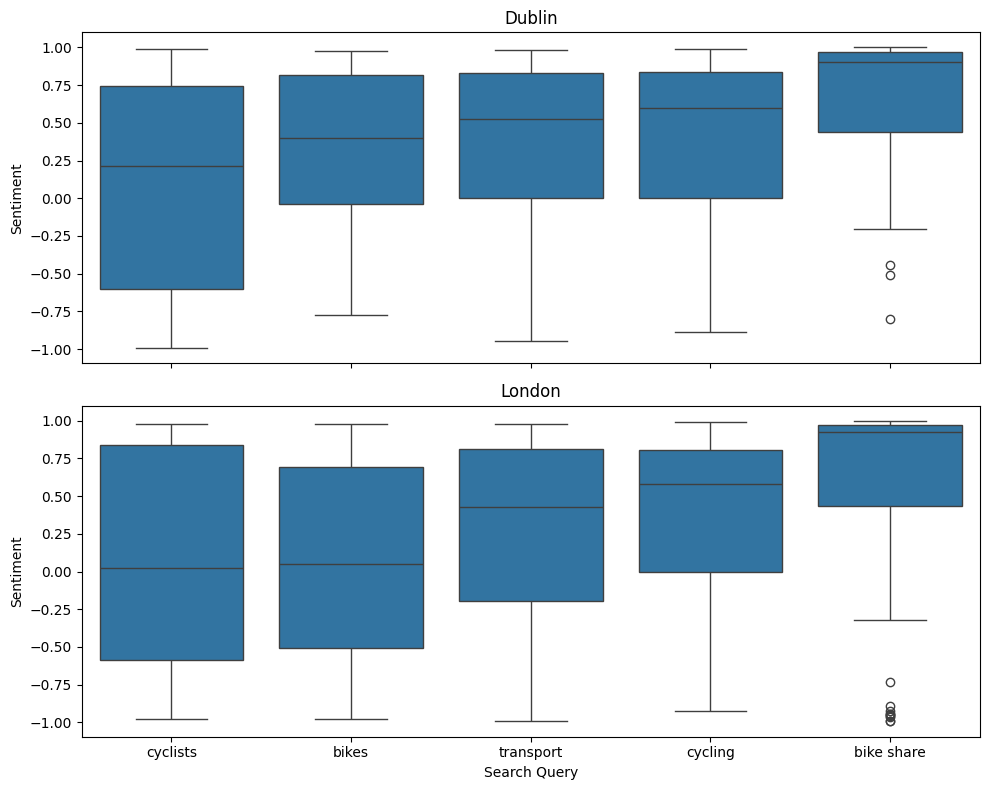

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True, sharey=True)

sns.boxplot(ax=axes[0], data = analyzed_sentiment_df[analyzed_sentiment_df['subreddit'] == 'Dublin'], x='search_query', y='compound')
sns.boxplot(ax=axes[1], data = analyzed_sentiment_df[analyzed_sentiment_df['subreddit'] == 'london'], x='search_query', y='compound')
axes[0].set_title('Dublin')
axes[1].set_title('London')
axes[1].set_xlabel('Search Query')
axes[0].set_ylabel('Sentiment')
axes[1].set_ylabel('Sentiment')

plt.tight_layout()

plt.show();

r/london appears to be more negative about "cyclists", "bikes", and "transport", whereas r/dublin and r/london are roughly tied in sentiment on the terms "cycling" and "bike share". It appears as though the average sentiment towards each of the terms investigated is generally positive in both subreddits.

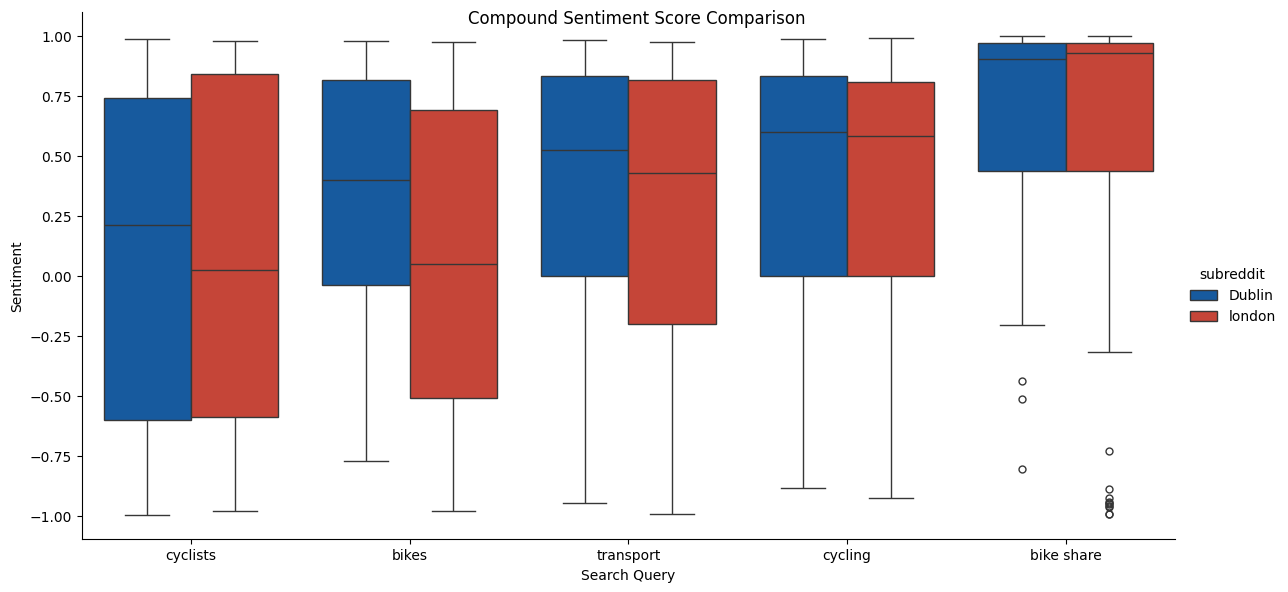

In [79]:
# Using palette retrieved from colouring for colourblindness
g = sns.catplot(x='search_query', y='compound', hue='subreddit', kind='box', palette=['#005AB5', '#DC3220'], data=analyzed_sentiment_df, height=6, aspect=2)
plt.suptitle('Compound Sentiment Score Comparison')
g.set_axis_labels('Search Query', 'Sentiment')
plt.show();